# Project: Explore weather trends

## Data preparation

Sacramento (in United States) is the closest city to Folsom where I live. The following SQL query was used to get average temperature for the world and Sacramento from the database:

SELECT city_data.year, city_data.avg_temp AS sacramento_avg_temp, global_data.avg_temp AS global_avg_temp   
FROM city_data   
JOIN global_data   
ON city_data.year = global_data.year  
WHERE country='United States' AND city='Sacramento'  
ORDER BY year

The output of the above query was downloaded as a CSV file and opened in Microsoft Excel. The steps used in the moving averages exercise in the project section were used to add two new columns with a ten year moving average for global and Sacramento temperatures.

## Data visualization

We load the data from the CSV file using the pandas library in Python using the code below.

In [46]:
import pandas as pd

avg_temp_df = pd.read_csv('avg_temp_data.csv')
avg_temp_df.head()

,year,sacramento_avg_temp,global_avg_temp,sacramento_10_year_MA,global_10_year_MA
0,1849,14.12,7.98,NaN,NaN
1,1850,13.80,7.90,NaN,NaN
2,1851,14.39,8.18,NaN,NaN
3,1852,13.81,8.10,NaN,NaN
4,1853,14.40,8.04,NaN,NaN


Since moving average values start from year 1858 we drop the rows above it in the DataFrame.

In [2]:
avg_temp_df=avg_temp_df.drop(range(0,9))
avg_temp_df.head()

,year,sacramento_avg_temp,global_avg_temp,sacramento_10_year_MA,global_10_year_MA
9,1858,14.19,8.10,14.177,8.038
10,1859,13.71,8.25,14.136,8.065
11,1860,13.81,7.96,14.137,8.071
12,1861,14.88,7.85,14.186,8.038
13,1862,14.43,7.56,14.248,7.984


We plot the average temperatures over time for Sacramento and the world using the code below.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

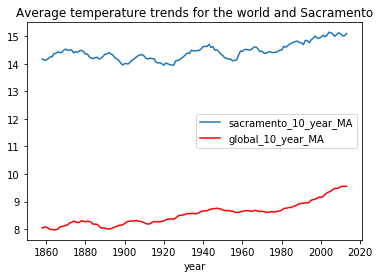

In [4]:
ax = plt.gca()
avg_temp_df.plot(x='year', y='sacramento_10_year_MA', ax=ax, 
                 title='Average temperature trends for the world and Sacramento')
avg_temp_df.plot(x='year', y='global_10_year_MA', color='red', ax=ax)

In order to visualize how correlated the global and Sacramento temperatures are, we create a scatter plot using the code below.

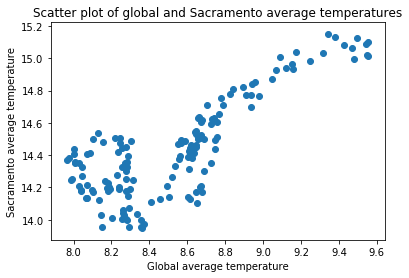

In [5]:
avg_temp_sac = avg_temp_df['sacramento_10_year_MA']
avg_temp_global = avg_temp_df['global_10_year_MA']
plt.scatter(avg_temp_global, avg_temp_sac)
plt.title('Scatter plot of global and Sacramento average temperatures')
plt.xlabel('Global average temperature')
plt.ylabel('Sacramento average temperature')
plt.show()

We use the following function to calculate Pearson's r (correlation coefficient) between global and Sacramento average temperatures.

In [6]:
def correlation(x, y):
    
    x_standard = (x - x.mean())/x.std(ddof=0)
    y_standard = (y - y.mean())/y.std(ddof=0)
    prod = x_standard*y_standard
    
    return prod.mean()

print("Pearson's r between global and Sacramento temperatures: ", correlation(avg_temp_global, avg_temp_sac))

Pearson's r between global and Sacramento temperatures:  0.8160181708830238


## Data interpretation and insights

We can make the following observations based on the graph above:
1. Sacramento is hotter compared to the global average temperature. The trend seems to be consistent over time.
2. The scatter plot of global and Sacramento average temperatures is shown before. We can see that they follow a non-linear relationship till the global average temperature reaches around 8.4. Beyond that point the relationship is almost linear. 
3. Pearson's r is calculated in the code above. The r value is close to 1, which means that the overall relationship is almost linear. 
4. We can clearly see that the global average temperature is rising overall with time. There were drops around the years 1890 and 1955. But there is a steady increase after the year 1980. 
5. The average temperature for Sacramento follows similar trends as the global average after the year 1930. There are few differences between the two before the year 1930. There was a drop in global average around the year 1890, while the opposite occured for Sacramento.

### Estimating average temperature in Sacramento

Since we found out that the relationship between global and Sacramento average temperatures is almost linear after the global value reaches 8.4, we can try to use linear regression to estimate the average temperature for Sacramento based on global average temperature. We calculate the corresponding values for Sacramento where global value is greater than 8.4 and use Ridge regression (which uses L2 regularization) to see how well our model fits.

In [24]:
import numpy as np
linear_index = avg_temp_global > 8.4
linear_avg_temp_global = np.array(avg_temp_global[linear_index]).reshape(-1,1)
linear_avg_temp_sac = np.array(avg_temp_sac[linear_index]).reshape(-1,1)

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(linear_avg_temp_global, linear_avg_temp_sac, random_state=42)
ridge = Ridge(alpha=0.1).fit(X_train, y_train)
print('Training set score: %0.2f' % (ridge.score(X_train, y_train)))
print('Test set score: %0.2f' % (ridge.score(X_test, y_test)))

Training set score: 0.76
Test set score: 0.84


We can see that the Ridge regression model has an accuracy of 84% with a regularization parameter alpha=0.1. Since the relationship is not exactly linear, we might be able to get a better fit by using a quadratic or third degree polynomial as shown below.

In [44]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
poly_avg_temp_global = poly.fit_transform(linear_avg_temp_global)
X_train, X_test, y_train, y_test = train_test_split(poly_avg_temp_global, linear_avg_temp_sac, random_state=42)
ridge = Ridge(alpha=0.1).fit(X_train, y_train)
print('Training set score: %0.2f' % (ridge.score(X_train, y_train)))
print('Test set score: %0.2f' % (ridge.score(X_test, y_test)))

Training set score: 0.82
Test set score: 0.87


The code above uses a cubic polynomial to model the average temperature for Sacramento ($y$) as a function of the global average ($x$). The relationship is $y = \theta_0 + \theta_1x +\theta_2x^2 + \theta_3x^3$, where $\theta_0, \theta_1, \theta_2$ and $\theta_3$ are the weights learned by the model. We see that we get slightly better accuracy (87%) compared to the linear model.

## References

- Intro to Data Analysis (free udacity course)
- Introduction to Machine Learning with Python, by Andreas C. Muller and Sarah Guido
- https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions